# Analysis of UK House Market Data
We are going to analyse the market data from the UK housing market, with a dataset in a .CSV format downloaded from [kaggle](https://www.kaggle.com/datasets/lorentzyeung/price-paid-data-202304).
The data has been sourced from the UK government's HM Land Registry for the time period of 1995 - 2023-05-01.


# 1.0 Importing the tools we are going to use
* Pandas
* Numpy
* Matplotlib
* Plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl

# 1.1 Creating an instance of the read CSV file

In [2]:
uk_house_data_all = pd.read_csv(
    'datasets/uk_house_market_data.csv',
    names=[
        'Transaction_unique_identifier',
        'price',
        'date_of_sale',
        'postcode',
        'property_type',
        'old_new',
        'duration',
        'PAON',
        'SAON',
        'street',
        'locality',
        'town_city',
        'district',
        'county',
        'ppd_category_type',
        'record_status',
    ],
    dtype={'price': 'int64'}
)


# 1.2 Creating a smaller set of data
We won't need all the data from the dataset, so we make a smaller one to increase processing speed

In [3]:
sales_data_20_years = uk_house_data_all.query('date_of_sale >= "2000-01-01 00:00"')

# 2.0 Extracting data from year 2015 to 2023
Extracting the data from 2015 to 2023, so we can:
* Compare sales through the years
* Determine sales trends
    * Best property selling months
    * Worst property selling months
    * Average properties sold

**Methodology**
Create a dictionary to store the data for each year, we store a string with sales_data_{year} as **keys** and the results of the dataset for the time period of that year as **values**

In [4]:
yearly_data_since_2015 = {}

for year in range(2015, 2024):
    name = f"sales_data_{year}"
    values = sales_data_20_years[sales_data_20_years['date_of_sale'].str.startswith(f'{str(year)}')]
    yearly_data_since_2015[name] = values


# 2.1 Count properties sold for each year
Here we are going to create two new dictionaries:
1. To store the count of all properties sold throughout those years
2. To store the count of properties sold until May of each year

**We need to have a second dictionary with the count of properties sold until May, because the dataset ends in May 2023, and it will be inappropriate to compare yearly data for a year that hasn't got all the data collected yet.**

In [5]:
yearly_properties_sold = {
    int(key[-4:]) : value['date_of_sale'].count()
    for key, value in yearly_data_since_2015.items()
}

yearly_properties_sold_until_may = {}

for key, value in yearly_data_since_2015.items():
    year = key[-4:]
    till_may = value.loc[value['date_of_sale'] <= f"{year}-05-01"]
    yearly_properties_sold_until_may[year] = till_may['date_of_sale'].count()   

# 2.2 Visualize the results
Visualizing the yearly property sold until May

<BarContainer object of 9 artists>

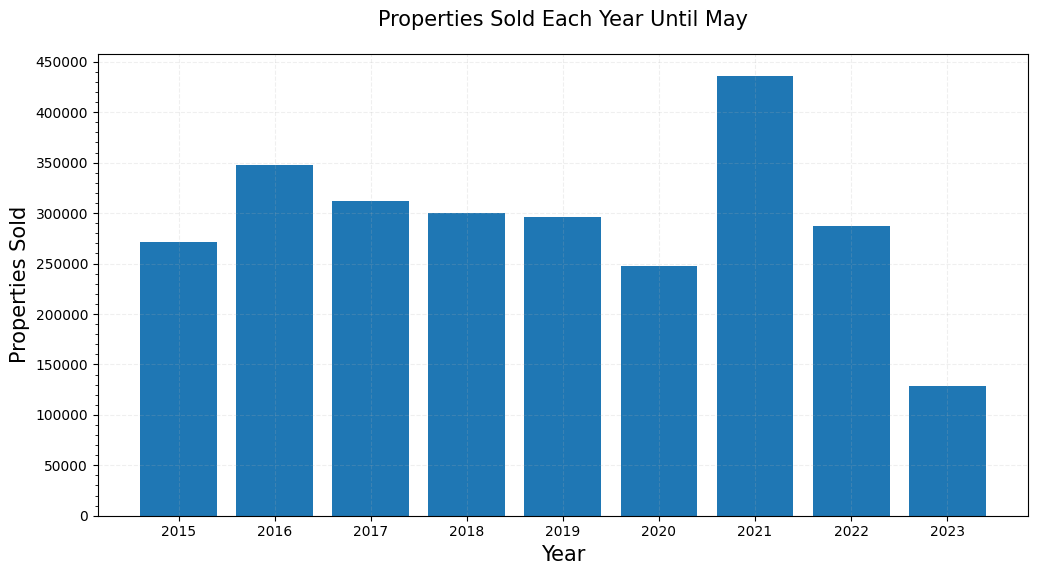

In [6]:
from matplotlib.pyplot import MultipleLocator

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')
ax.set_title('Properties Sold Each Year Until May', fontsize=15, pad=20)
plt.ylabel('Properties Sold', fontsize=15)
plt.xlabel('Year', fontsize=15)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(50000))
ax.yaxis.set_minor_locator(MultipleLocator(10000))

ax.bar(
    yearly_properties_sold_until_may.keys(), yearly_properties_sold_until_may.values()
)


# 2.3 Average Properties Sold
**Finding out the average properties sold for the year 2015-2023 and displaying how is 2023 compared to the average**
* Get the sum of the values in the properties_sold_until_may dictionary and divide with the length of the values()
* Find the percentage change of properties sold to the average
* Display it in a fig with two ax

Text(0, 0.5, 'In Percent')

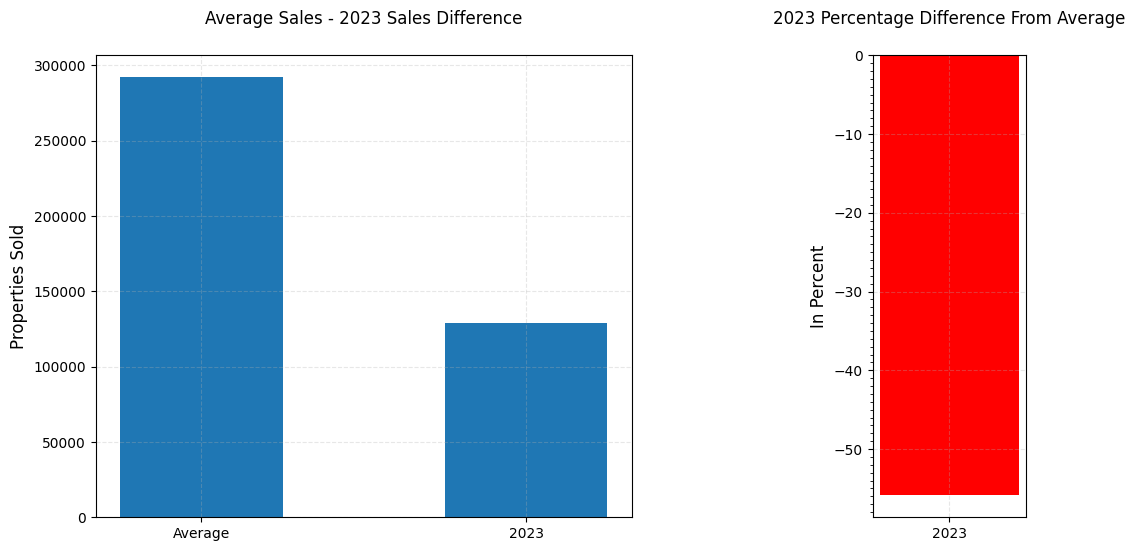

In [7]:
average_properties_sold_until_may_2015_2023 = sum(yearly_properties_sold_until_may.values()) / len(yearly_properties_sold_until_may.values())

values_to_compare = [
    average_properties_sold_until_may_2015_2023,
    yearly_properties_sold_until_may['2023']
]

percentage_difference_average_and_2023 = (
    (
            (yearly_properties_sold_until_may['2023'] - average_properties_sold_until_may_2015_2023) / average_properties_sold_until_may_2015_2023
    ) * 100
)

width_ratios = [7, 2]
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': width_ratios})
plt.subplots_adjust(wspace=0.7)
ax[0].grid(True, alpha=0.3, ls='dashed')
ax[0].set_title('Average Sales - 2023 Sales Difference', y=1.05)
ax[0].bar(['Average', '2023'], values_to_compare, width=0.5, align='center')
ax[0].set_ylabel('Properties Sold', fontdict={'fontsize': 12})

ax[1].grid(True, alpha=0.3, ls='dashed')
ax[1].set_title('2023 Percentage Difference From Average', y=1.05)
ax[1].bar('2023', percentage_difference_average_and_2023, color='red')
ax[1].yaxis.set_minor_locator(MultipleLocator(1))
ax[1].set_ylabel('In Percent', fontdict={'fontsize': 12})


# 2.3.1 Conclusion
The first 4 months of properties sold in 2023 have decreased by slightly over 55% which was primarily driven by high interest rates in combination with high inflation and high property prices.

*Note:*
*Get interest rate data to make comparison better*

# 2.4 Compare all years to a three years moving average
Compare every year property sales data until May, from 2017 to 2023
**We compare prices from 2017, because in order to get 3 years moving average we need to collect data from 2 years prior the current year**

Steps:
* Create pd.Series with the data from the dictionary about each year sales until May  *Having 'sold' column*
* Convert it into a pd.DataFrame and reset the index *The previous index column will be renamed to 'year'*
* Create new column 'moving_average' which will be the rolling(window=3).mean of the 'sold' column
* Create a new column 'percentage_change' to store the percentage representation of the the difference between the years sold properties and the 3 years moving average
* Drop any N/A rows

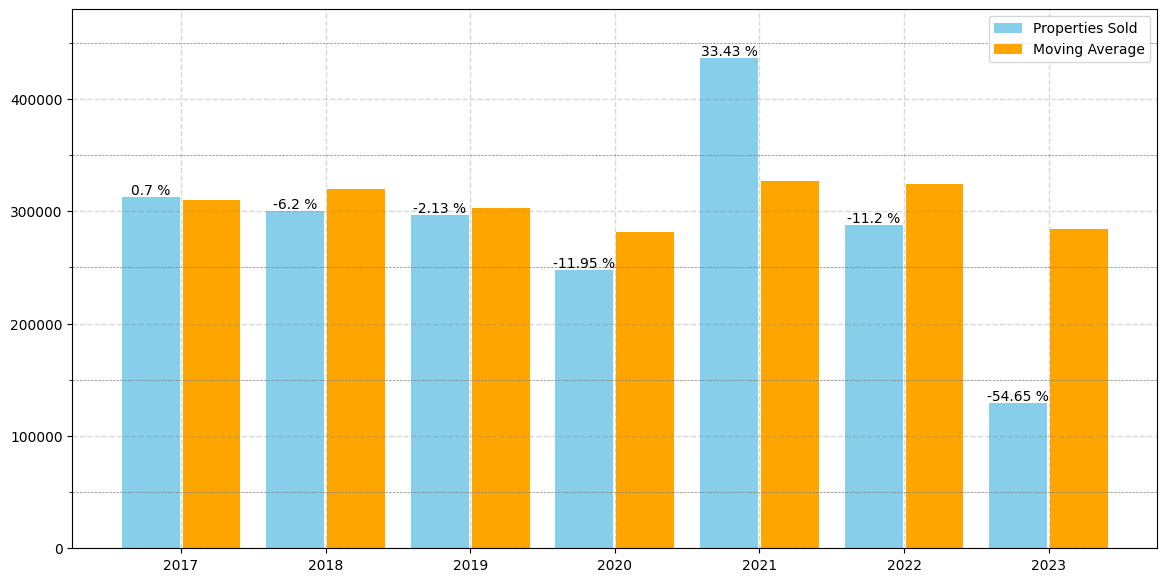

In [8]:
three_year_moving_average_sales = pd.Series(yearly_properties_sold_until_may, name='sold').to_frame().reset_index(names=['year'])
three_year_moving_average_sales['moving_average'] = three_year_moving_average_sales['sold'].rolling(window=3).mean().round()
three_year_moving_average_sales = three_year_moving_average_sales.dropna()
three_year_moving_average_sales['percentage_change'] = round(((three_year_moving_average_sales['sold'] - three_year_moving_average_sales['moving_average']) / three_year_moving_average_sales['moving_average'] * 100), 2)
three_year_moving_average_sales['year'] = pd.to_numeric(three_year_moving_average_sales['year'])

fig, ax = plt.subplots(figsize=(14, 7))
ax.grid(True, alpha=0.3, ls='dashed', color='gray', lw=1)
ax.grid(True, which='minor', ls='dashed', lw=0.5, color='gray')

bar_width = 0.4
bar_positions = three_year_moving_average_sales['year']

sold= ax.bar(bar_positions - bar_width / 1.9, three_year_moving_average_sales['sold'], bar_width, label='Properties Sold', color='skyblue')
moving_average = ax.bar(bar_positions + bar_width / 1.9, three_year_moving_average_sales['moving_average'], bar_width, label='Moving Average', color='orange')
ax.legend()
ax.yaxis.set_major_locator(MultipleLocator(100000))
ax.yaxis.set_minor_locator(MultipleLocator(50000))
ax.bar_label(sold, [f"{pct} %" for pct in three_year_moving_average_sales['percentage_change']])
ax.margins(y=0.1)
plt.show()



# 2.5 Check correlation between sales and interest rates
*Steps*:
* Find and import historic interest-rate data
* Process the data to our needs
* Find out correlation between interest-rates and property sales
* Visualise the results

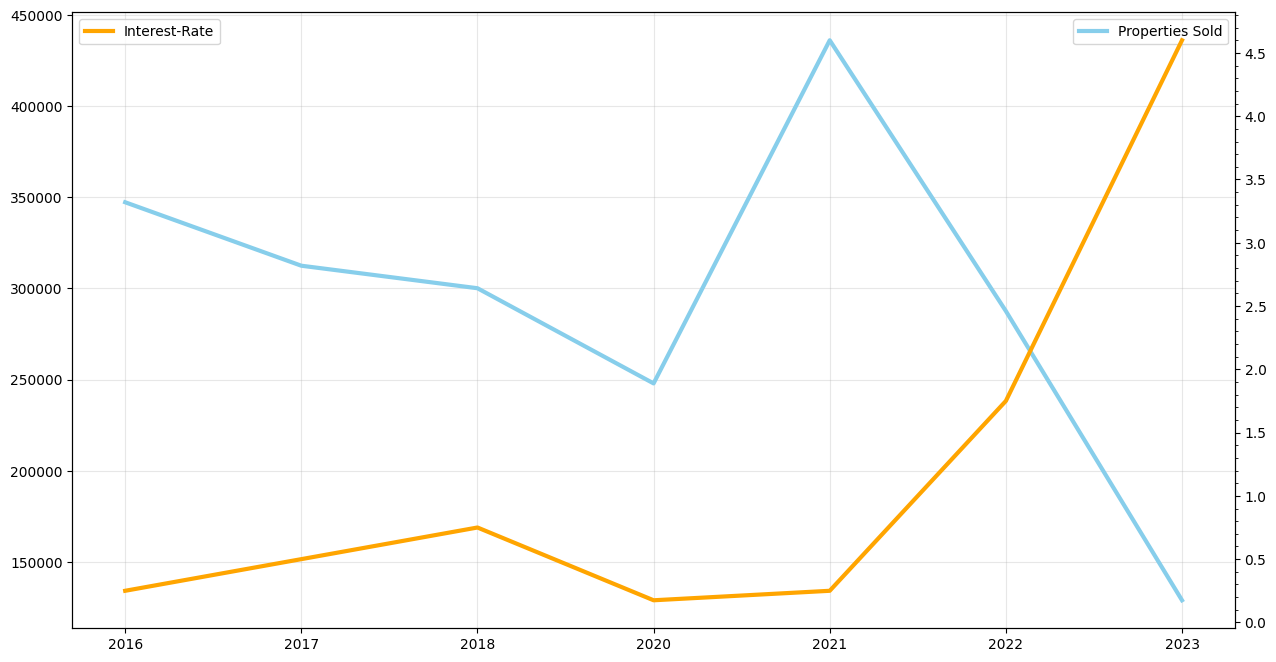

In [148]:
# Read the data and format it to what we need
interest_rates_data = pd.read_csv('datasets/Bank Rate history and data Bank of England Database.csv')

interest_rates_data['Date Changed'] = pd.to_datetime(interest_rates_data['Date Changed'], format='%d %b %y')

yearly_average_interest_rates = interest_rates_data['Rate'].groupby(interest_rates_data['Date Changed'].dt.strftime('%Y')).mean().to_frame()


yearly_average_interest_rates_2015_2023 = yearly_average_interest_rates.loc[yearly_average_interest_rates.index >= '2015']

properties_sold_till_may_frame = pd.Series(yearly_properties_sold_until_may).to_frame(name='Sold').drop(index=['2015'])


correlation = yearly_average_interest_rates_2015_2023['Rate'].corr(
    properties_sold_till_may_frame['Sold']
)

concatenated_frame = pd.concat(
    [
        properties_sold_till_may_frame,
        yearly_average_interest_rates_2015_2023
     ],
    axis=1
).dropna()

# Plot it on a shared x-axis
fig, ax = plt.subplots(figsize=(15, 8), sharey=True)
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax.plot(concatenated_frame['Sold'], label='Properties Sold', color='skyblue', lw=3)
ax2.plot(concatenated_frame['Rate'], label='Interest-Rate', color='orange', lw=3)

ax.legend()
ax2.legend()
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))


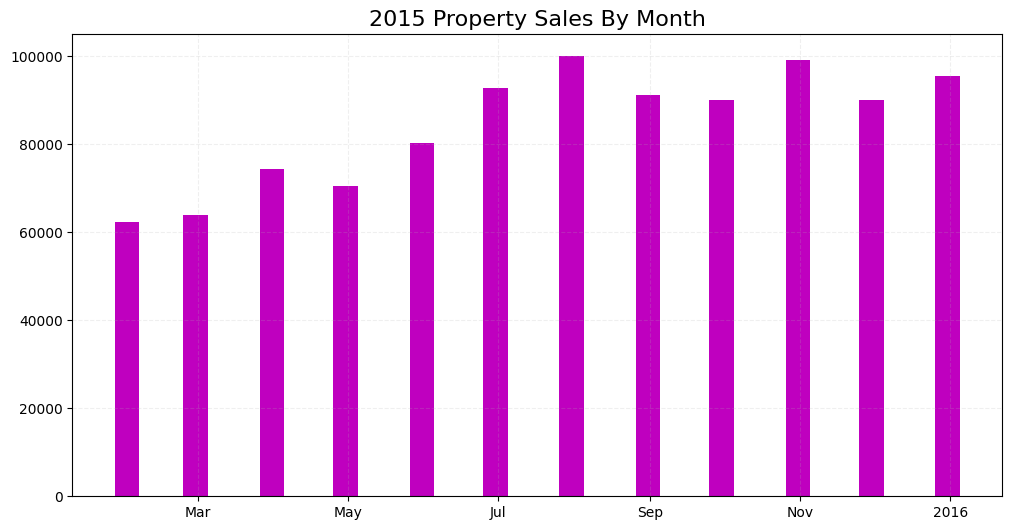

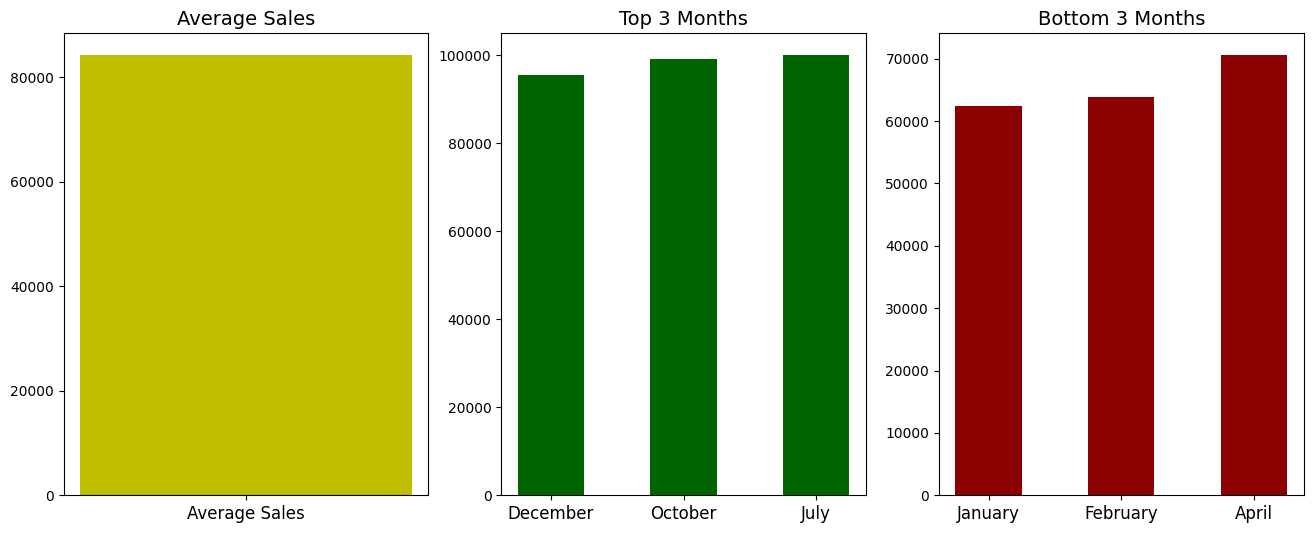

In [9]:
data_for_2015 = yearly_data_since_2015['sales_data_2015'].copy()
data_for_2015['date_of_sale'] = pd.to_datetime(data_for_2015['date_of_sale'])
data_for_2015 = data_for_2015.sort_values('date_of_sale')
monthly_sales_for_2015 = data_for_2015.groupby(pd.Grouper(key='date_of_sale', freq='M')).size().reset_index(name='count')


fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')

cdf = mpl.dates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(cdf)
ax.set_title('2015 Property Sales By Month', fontsize=16)

x = monthly_sales_for_2015['date_of_sale']
y = monthly_sales_for_2015['count']
ax.bar(x, y, color='m', width=10,)

# sorting by sales, giving average, top 3 months and bottom 3 months
monthly_sales_for_2015 = monthly_sales_for_2015.sort_values('count')
average = monthly_sales_for_2015['count'].mean()

# Getting the info for the bottom 3 months and creating a new column to store the month name
bottom_3 = monthly_sales_for_2015.head(3).copy()
bottom_3['month_name'] = bottom_3['date_of_sale'].dt.strftime('%B')

# Getting the info for top 3 months, then creating a new column that stores only the months name
top_3 = monthly_sales_for_2015.tail(3).copy()
top_3['month_name'] = top_3['date_of_sale'].dt.strftime('%B')

fig, ax = plt.subplots(1, 3,figsize=(16, 6))

# Displaying the average sales
ax[0].bar(['Average Sales',], [average], lw=0.5, color='y')
ax[0].set_title('Average Sales', fontsize=14)
ax[0].yaxis.set_major_locator(MultipleLocator(20000))

# Displaying the top 3 months
ax[1].bar(top_3['month_name'], top_3['count'], lw=0.5, width=0.5, align='center', color='darkgreen')
ax[1].set_title('Top 3 Months', fontsize=14)

# Displaying the bottom 3 months
ax[2].bar(bottom_3['month_name'], bottom_3['count'], lw=0.5, width=0.5, align='center', color='darkred')
ax[2].set_title('Bottom 3 Months', fontsize=14)

for axis in ax:
    
    for tick_label in axis.get_xticklabels():
        tick_label.set_fontsize(12)


In [10]:
interest_rates_data = pd.read_csv('datasets/Bank Rate history and data Bank of England Database.csv')

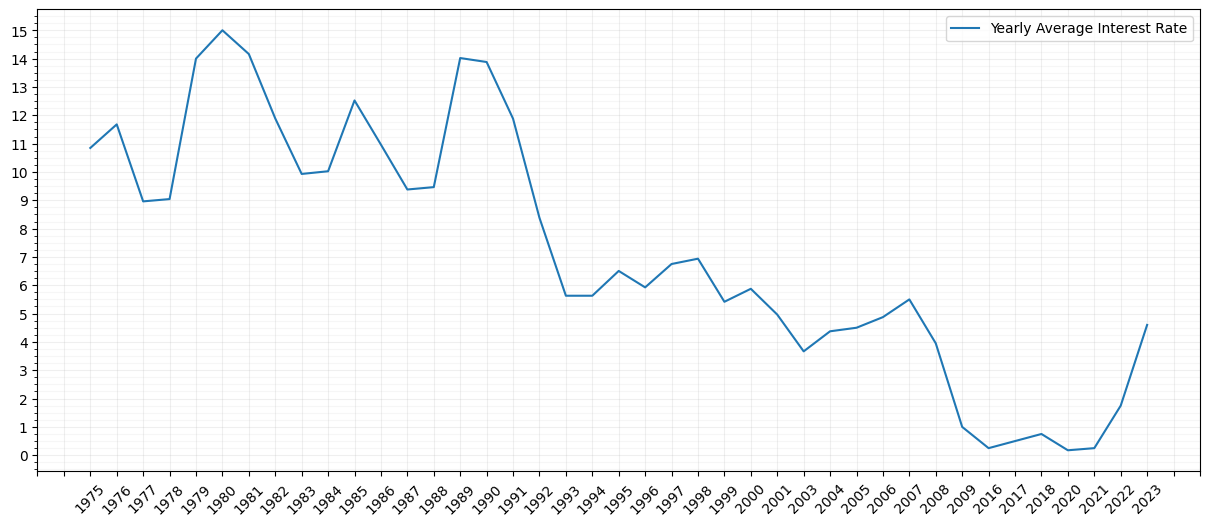

In [135]:
interest_rates_data['Date Changed'] = pd.to_datetime(interest_rates_data['Date Changed'], format('YYYY-DD-MM'))
yearly_average_interest_rates = interest_rates_data['Rate'].groupby(interest_rates_data['Date Changed'].dt.strftime('%Y')).mean().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
ax.grid(True, alpha=0.2)
ax.grid(True,which='minor', alpha=0.1)
ax.plot(yearly_average_interest_rates['Date Changed'], yearly_average_interest_rates['Rate'], label='Yearly Average Interest Rate')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(12))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.legend()

for tick_label in ax.get_xticklabels():
    tick_label.set_rotation(45)

